In [1]:
import pandas as pd
import numpy as np

from gensim.corpora import Dictionary
import ruptures as rpt

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_json('data/yle-tokenized-dev.json', orient='records')

In [3]:
df.head()

,id,date,title,body,subjects,tokens
0,3-9375096,2016-12-27T21:07:56+0200,Liverpool sahasi Stoken aivan sekaisin,,"[urheilu, englannin, valioliiga, stoke, city, ...","[liverpool, sahasi, stoken, aivan, sekaisin]"
1,20-194518,2017-06-09T12:43:12+0300,Jazzin show-mies Rahsaan Roland Kirk puhalsi s...,,"[rahsaan, roland, kirk, saksofoni, huilu, mult...","[jazzin, show, mies, rahsaan, roland, kirk, pu..."
2,20-217168,2014-07-29T11:35:19+0300,Loost Koosin Särre lähtee sooloilemaan – video...,,"[särre, miika, särmäkari, ylex, suomirap, ruud...","[loost, koosin, särre, lähtee, sooloilemaan, v..."
3,3-6234345,2012-07-29T11:53:59+0300,Räikköstä povataan takaisin Ferrarille,,"[urheilu, formula, 1, moottoriurheilu, ferrari...","[räikköstä, povataan, takaisin, ferrarille]"
4,3-9472646,2017-02-21T19:00:09+0200,Video: TsSKA sai apuja tuomareilta – Jokerien ...,,"[urheilu, khl, pfk, tsska, moskova, jokerit, u...","[video, tsska, sai, apuja, tuomareilta, jokeri..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        20000 non-null  object
 1   date      20000 non-null  object
 2   title     20000 non-null  object
 3   body      20000 non-null  object
 4   subjects  20000 non-null  object
 5   tokens    20000 non-null  object
dtypes: object(6)
memory usage: 937.6+ KB


In [5]:
# convert date string to date object and normalize to ignore the time
df['date'] = pd.to_datetime(df['date'], utc=True)

In [6]:
df.head()

,id,date,title,body,subjects,tokens
0,3-9375096,2016-12-27 19:07:56+00:00,Liverpool sahasi Stoken aivan sekaisin,,"[urheilu, englannin, valioliiga, stoke, city, ...","[liverpool, sahasi, stoken, aivan, sekaisin]"
1,20-194518,2017-06-09 09:43:12+00:00,Jazzin show-mies Rahsaan Roland Kirk puhalsi s...,,"[rahsaan, roland, kirk, saksofoni, huilu, mult...","[jazzin, show, mies, rahsaan, roland, kirk, pu..."
2,20-217168,2014-07-29 08:35:19+00:00,Loost Koosin Särre lähtee sooloilemaan – video...,,"[särre, miika, särmäkari, ylex, suomirap, ruud...","[loost, koosin, särre, lähtee, sooloilemaan, v..."
3,3-6234345,2012-07-29 08:53:59+00:00,Räikköstä povataan takaisin Ferrarille,,"[urheilu, formula, 1, moottoriurheilu, ferrari...","[räikköstä, povataan, takaisin, ferrarille]"
4,3-9472646,2017-02-21 17:00:09+00:00,Video: TsSKA sai apuja tuomareilta – Jokerien ...,,"[urheilu, khl, pfk, tsska, moskova, jokerit, u...","[video, tsska, sai, apuja, tuomareilta, jokeri..."


In [76]:
type(df.iloc[0]['date'])

pandas._libs.tslibs.timestamps.Timestamp

In [10]:
def build_dictionary(tokens, save_path):
    """
    Build dictionary from tokens list to get unique vocab
    """
    dct = Dictionary(tokens)
    dct.save(save_path)
    
    return dct

def get_term_doc_freq(dictionary, token):
    """
    Get the term frequency, and number of docs contain that term
    """
    term_id = dictionary.token2id[token]
    term_freq = dictionary.cfs[term_id]
    doc_freq = dictionary.dfs[term_id]
    return term_freq, doc_freq

def count_terms_per_doc(dictionary, docs_tokens):
    """
    Get the terms frequency in all doc
    return: List of tuple (term_id, freq_in_doc)
    """
    freq_list = []
    for tokens in docs_tokens:
        terms_freq = dictionary.doc2bow(tokens)
        freq_list.append(terms_freq)
    
    return freq_list

def query_term(term, docs_terms_freq, dictionary):
    """
    Map term freq to articles by date
    """
    term_id = dictionary.token2id[term]
    count = np.zeros(len(docs_terms_freq), dtype=int)
    
    for i, doc in enumerate(docs_terms_freq):
        for freq in doc:
            if term_id == freq[0]:
                count[i] = freq[1]
                continue
    
    return count
    
    
    

def visualize_term_freq(df, freq):
    df_freq = df[['id', 'date']].copy()
    df_freq['freq'] = freq
    # df_freq.index = pd.to_datetime(df_freq.index)
    print(type(df_freq.iloc[0]['date']))
    
    df_freq['Year'] = df_freq['date'].dt.year
    df_freq['Month'] = df_freq['date'].dt.month
    df_freq['Weekday'] = df_freq['date'].dt.weekday
    
    df_freq.set_index('date', inplace=True)

    df_agg = df_freq.groupby(['Year', 'Month']).agg({'id': 'first', 'freq': 'sum'})
    
    print(df_agg.head())
    
    sns.set(rc={'figure.figsize':(20, 5)})
    ax = df_agg['freq'].plot(marker='o', linestyle='-')
    ax.set_ylabel('Frequency by month');
    plt.show()
    
    return df_agg


In [8]:
dictionary = build_dictionary(df['tokens'], save_path='models/dev/dictionary.pkl')

In [5]:
dictionary = Dictionary.load('models/dev/dictionary.pkl')

In [25]:
dictionary[53]

'olivat'

In [26]:
dictionary.dfs[53]

809

In [11]:
%%time
docs_terms_freq = count_terms_per_doc(dictionary, df['tokens'])

CPU times: user 189 ms, sys: 5 ms, total: 194 ms
Wall time: 194 ms


In [30]:
# docs_term_freq[78]

In [13]:
query_key = "suomi"
query_freq = query_term(query_key, docs_terms_freq, dictionary)

In [89]:
# Now we can visualize the term frequency density in timeline

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
                   id  freq
Year Month                 
2010 12     3-5299869     0
2011 1      3-5302354     1
     2      3-5082401     1
     3      3-5331143     2
     4      3-5339642     0


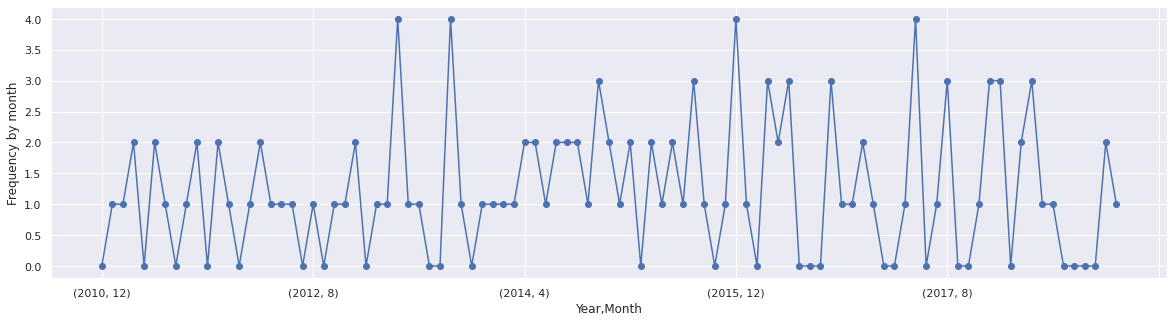

In [14]:
df_freq = visualize_term_freq(df, query_freq)

In [28]:
dictionary[15]

'ei'

In [30]:
dictionary.token2id['kuntavaalien']

7771

In [ ]:
# to visualize by term:
# term input => per_doc => per year

In [107]:
df_freq.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 96 entries, (2011, 1) to (2018, 12)
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      96 non-null     object
 1   freq    96 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.9+ KB


[0 1 1 2 0 2 1 0 1 2]
[ 0 19 38 57 76 95]


<Figure size 1440x720 with 0 Axes>

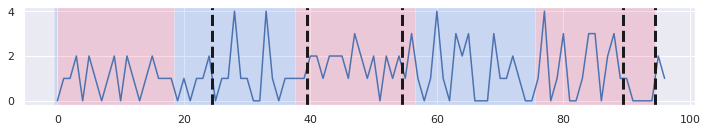

In [16]:
# generate signal
# n_samples, dim, sigma = 1000, 1, 1
n_bkps = 5  # number of breakpoints

# signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)
signal = df_freq['freq'].to_numpy()
bkps = np.arange(0, len(signal), int(len(signal) / n_bkps), dtype=int)
print(signal[:10])
print(bkps)
# detection
algo = rpt.Dynp(model="rbf").fit(signal)
result = algo.predict(5)
# display

plt.figure(figsize=(20,10))
rpt.display(signal, bkps, result)

plt.show()
